# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "alexis"
ln1 = "gerbeaux"
fn2 = "manon"
ln2 = "rivoire"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_gerbeaux_alexis_and_rivoire_manon.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x, -grad_x, grad_x, c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

In [98]:
#?optimize.line_search

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


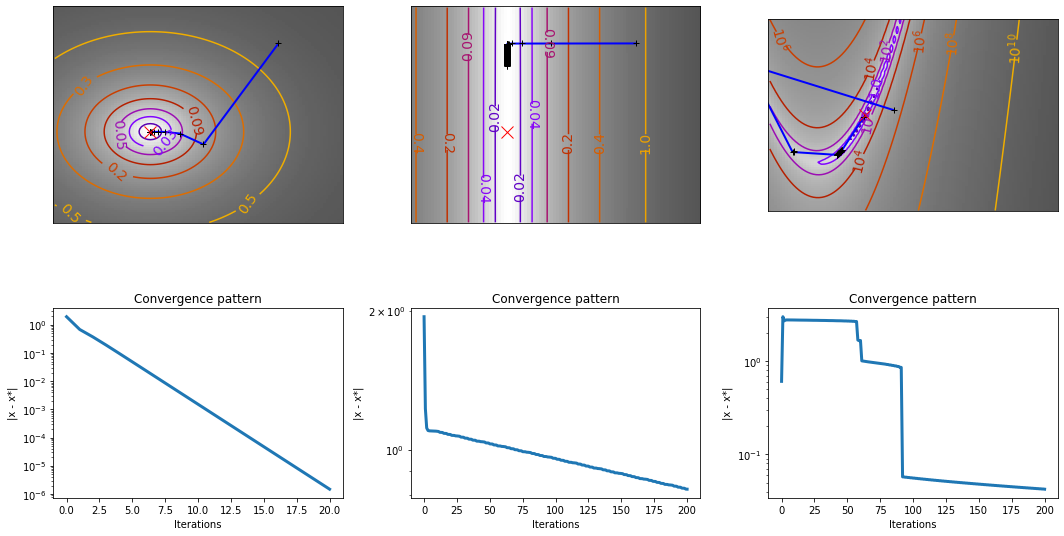

In [7]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [103]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = C1 #0.00001
    c2 = C2 # 0.95
    max_iter = 100
    lambda_threshold = threshold #  regularization threshold

    #  This variable is used to indicate whether or not we want to print
    #  monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO 
        H = f_hessian(x)
        sigma_min = np.linalg.eigvalsh(H).min()

        if sigma_min < lambda_threshold:
            H += (lambda_threshold - sigma_min)*np.eye(H.shape[0])

        # We solve the system composed of the hessian of f(x) times the grad of f(x) which takes part in the update given by the newton method
        d = -np.linalg.solve(H, grad_x) 

        # Compute a step size using a line_search to satisfy the strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x, d, grad_x, c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

<font color='blue'>

The aim of regularizing the hessian matrix is to fix the convergence issue of the Newton method. In order to solve this issue, the regularization reduces the conditioning if the threshold is bigger than the smallest eigen value of the hessian.

To well understand the impact of regularization on the Hessian matrix we are going to play with the threshold managing the regularization.
</font>


Running solver on case 1
iter: 1, f: 0.492695, l_inf_norm(grad): 0.486214
iter: 2, f: 0.0371229, l_inf_norm(grad): 0.244507
iter: 3, f: 0.0261662, l_inf_norm(grad): 0.221995
iter: 4, f: 0.0216736, l_inf_norm(grad): 0.202746
iter: 5, f: 0.0182897, l_inf_norm(grad): 0.186731
iter: 6, f: 0.0156504, l_inf_norm(grad): 0.173082
iter: 7, f: 0.0135375, l_inf_norm(grad): 0.161234
iter: 8, f: 0.0118113, l_inf_norm(grad): 0.150802
iter: 9, f: 0.010378, l_inf_norm(grad): 0.14151
iter: 10, f: 0.00917188, l_inf_norm(grad): 0.133154
iter: 11, f: 0.00814572, l_inf_norm(grad): 0.125582
iter: 12, f: 0.00726453, l_inf_norm(grad): 0.118674
iter: 13, f: 0.00650182, l_inf_norm(grad): 0.112336
iter: 14, f: 0.00583717, l_inf_norm(grad): 0.106493
iter: 15, f: 0.00525457, l_inf_norm(grad): 0.101083
iter: 16, f: 2.09721e-13, l_inf_norm(grad): 6.41144e-07

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_

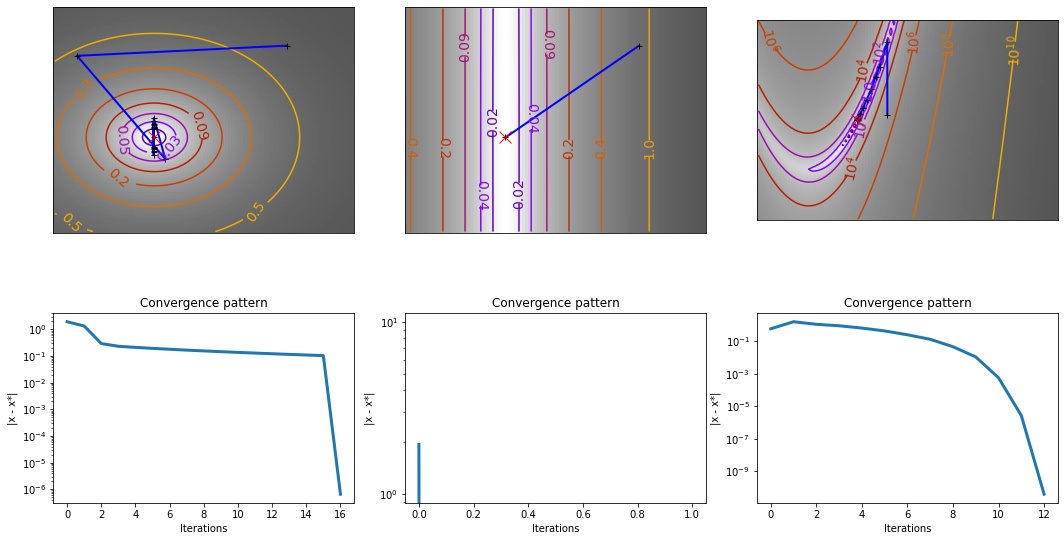

In [102]:
C1 = 0.00001
C2 = 0.95

threshold = 0.0001
test_solver(newton)


Running solver on case 1

Running solver on case 2

Running solver on case 3


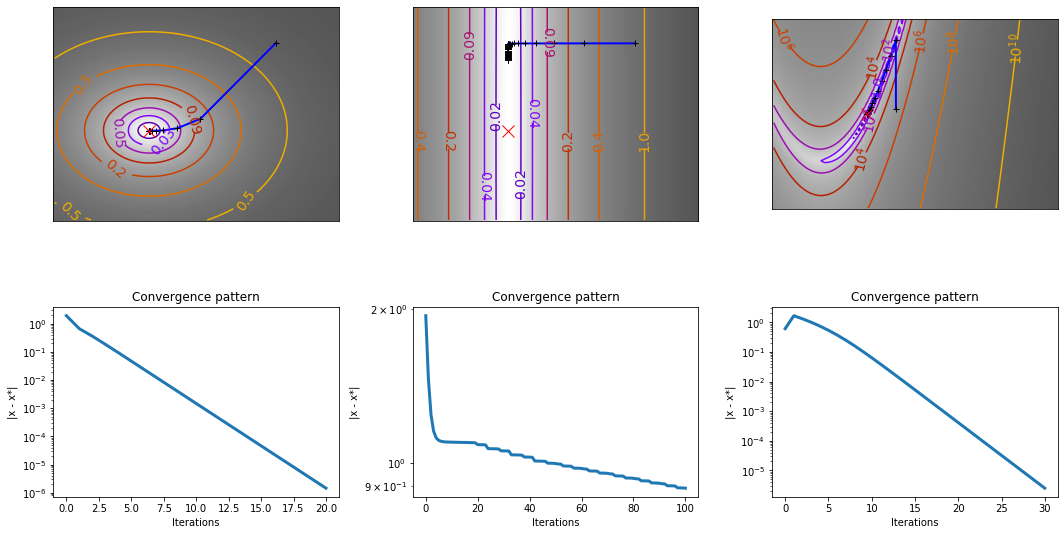

In [10]:
threshold = 1
test_solver(newton)


Running solver on case 1

Running solver on case 2

Running solver on case 3


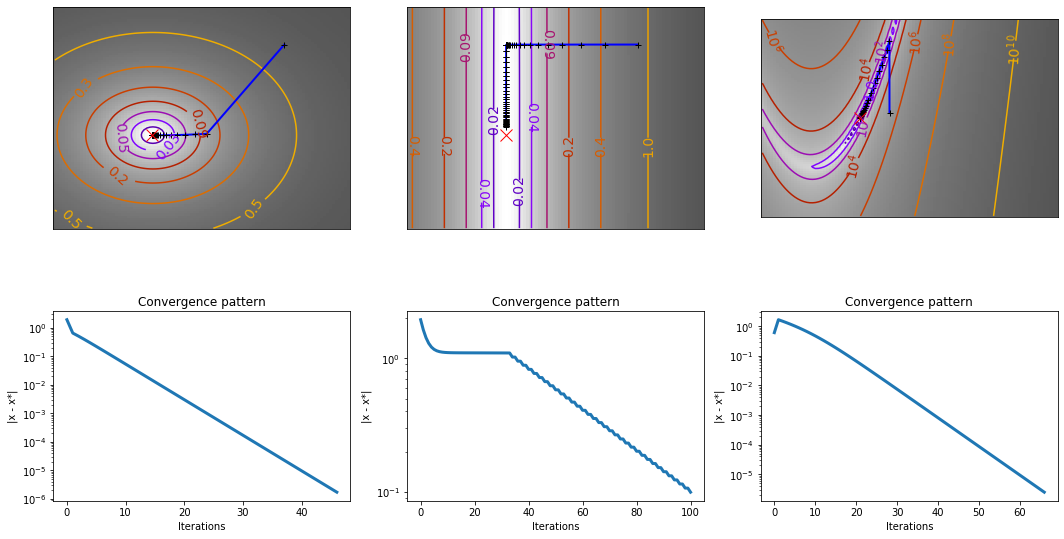

In [105]:
threshold = 2
test_solver(newton)

Only for the badly conditioned quadratic function (case 2)

Running solver on case 1

Running solver on case 2

Running solver on case 3


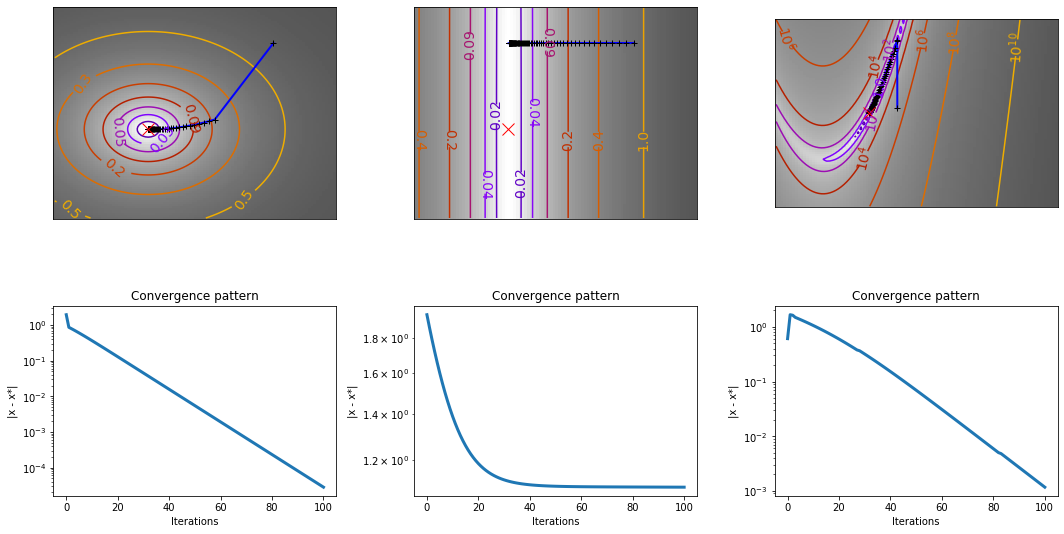

In [106]:
threshold = 10
print("Only for the badly conditioned quadratic function (case 2)")
test_solver(newton)

<font color='navy'>

**Impact of the regularization of the Hessian matrix onto the convergence of the Newton algorithm**

We can remark that the convergence of the Newton algorithm differs according to the regularization of the Hessian matrix. 

- Low Regularization (low lambda_threshold) <br/>
When the threshold managing the degree of regularization of the Hessian Matrix is low then, the regularization of the Hessian matrix is not very significant what implies that the convergence of the Newton Algorithm towards the optimum solution is very unstable and requires a large number of iterations. In this case, when we reach a large number of iterations the algorithm is located close to the optimum solution but it does not necessarily reach this optimum solution. 

- High Regularization (high lambda_threshold) <br/>
When the threshold managing the degree of regularization of the Hessian Matrix is high then, the degree of regularization of the Hessian matrix is high what implies that the convergence of the Newton Algorithm is more direct ie. doing less changes of direction. However, the approximated hessian differs from the true hessian and then the algorithm suffers from high bias issue and can converges towards a solution which is not the optimum solution. <br/>

Consequently, we have to find a trade off between a too low regularization term which can produce an difficult (eratic) convergence towards the optimum solution and a too high regularization term which can lead to a solution far from the minimum.
<font>

<font color='navy'>
    
**Comparison of the regularization of the Hessian matrix in the Newton Algorithm for the three different functions** 

- Low Regularization : 

**A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)** <br/>

  The non convex Gaussian Kernel is a very well conditioned function. In other words, the information held by the $d$ features of the model is uniformly spreaded with regards to the $d$ features, that is there is no principal component which holds more information than the other but each of the $d$ features holds the same proportion of the total information. <br/>
When the function is well conditioned the Newton Algorithm (as well as the Gradient Descent Algorithm and so on) is more able to easily converge towards the optimum solution and the speed of convergence is faster. Indeed, this is due to the fact that when the function is well conditioned, at each step of the algorithm, the move of the algorithm is the same in every direction, therefore, the slowdown of the algorithm towards the optimum solution is more straightforward and faster than with a badly conditioned funtion. <br/>

With a very low regularization term, the convergence of the Newton Algorithm towards the optimum solution for the non convex Gaussian Kernel may be "unstable", in other words the path followed by the successive iterates until the optimum solution is not straightforward and changes a lot of directions, but converges towards the optimum solution in a small number of iterations (only requires 16 iterations to reach the optimum solution). <br/> 

**The Rosenbrock function**

The Rosenbrock function is badly conditioned this implies that the information held by the $d$ features is not uniformly spreaded with regards to the $d$ features. This means that some of the $d$ features hold a more important part of the information and some others hold a less important part of the information. In other words, some of the features are more significant than others. <br/>
This implies that the convergence (slowdown) of the Newton Algorithm towards the optimum solution is not uniform but varies according to the direction chosen. Indeed, according to the direction, the update is more or less important according to the amount of information held by the feature chosen. Unlike the case where the function is well conditioned, in this case, the degree of importance of the successive updates to reach the optimum solution varies according to the amount of information held by the chosen feature. <br/>

We can notice that for the badly conditioned function, the convergence towards the optimum solution is very unstable what can be explained by the fact that the degree of importance of the successive updates varies in function of the chosen direction (since a badly conditioned function is anysotropic). However, the number of iterations required to reach the optimum solution is lower for a small regularization term than for a large regularization term, therefore the convergence towards the optimum solution is faster. It is in particular faster than the GD where the succesives iterates may always be out of the "valley" and thus never relly approching the solution even after more than 100 iterates.

**A badly conditioned quadratic function (but still strongly convex)** 
    
We can remark that even if the function is badly conditioned, as it is still strongly convex, the convergence of the Newton Algorithm towards the optimum solution is more stable than for a non strongly convex function since the slowdown of the Newton Algorithm is performed along with only two orthogonal directions. The optimum solution is reached at the first iteration if the hessian is not regularised. <br/>



- High Regularization <br/>

**A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)** 

For the non convex Gaussian Kernel, increasing the degree of regularization applied to the Hessian Matrix implies that we obtain a convergence towards the optimum solution which is almost linear, very more stable (with a lower number of elbows) than the one obtained with a small degree of regularization. The quasi linearization of the path followed by the successive iterates before reaching the optimum solution can be explained by the fact that the Regularization provides smaller succesive steps (updates). Therefore, when the algorithm does not choose the best direction to reach the optimum solution, since the steps are lower, then the algorithm is more able to correct the direction at the following iteration and to choose this time the proper direction. Thus, the sequence of these small successive steps is quasi linear and gives a more stable convergence towards the optimum solution. Howerver, since we decrease the size of the step, the algorithm requires a larger number of iterations to reach the optimum solution (20 and then 40 instead of 16). <br/> 


**The Rosenbrock function** 

For the Rosenbrock function which is badly conditioned, with an important term of regularization, we can remark that the convergence of the Newton Algorithm towards the optimum solution is slower. In the same way as previously, since when we add an important regularizaton to the Hessian Matrix, the size of the step decreases then the slowdown of the Newton Algorithm is composed of a larger number of iterations and the convergence towards the optimum solution is slower (30 and then 60 instead of 12 iterations).  <br/>

**A badly conditioned quadratic function (but still strongly convex)**
    
We can remark that even if the function is badly conditioned, as it is still strongly convex, the slowdown of the Newton Algorithm towards the optimum solution is still very stable, that is the path followed by the successive iterates before reaching the optimum solution is composed at most of one elbow (change of directions). This can be explained as follows : an important regularization of the Hessian Matrix rescales the successive steps such that the successive steps might be smaller and that the succession of these small steps might be more and more linear.  <br/>
 
We can also remark that the algorithm is no longer really converging if the threshold is very big (lambda=100). The regularization is too important and even in 100 iteration the minimum is not reached.

Therefore, we can conclude that we have to choose the degree of regularization of the Hessian Matrix with the knowledge of the function (convex or not, strongly convex or not, well conditioned or not and so on). And this degree of regularization plays a very important role in the convergence of the Newton Algorithm both from a point of view of the speed of convergence but also from a point of view of the form of the path followed by the successive iterates before reaching the optimum solution as well as the accuracy with which the algorithm manages to reach the optimum solution.

<font>

**Further explorations according to the parameters** 

Let's play with the parameters C1 and C2 in order to see the influence of these paramaters over the convergence of the Newton Algorithm.

######################################
             Effect of C1             
######################################
Convergence for C1 = 0.00001

Running solver on case 1

Running solver on case 2

Running solver on case 3


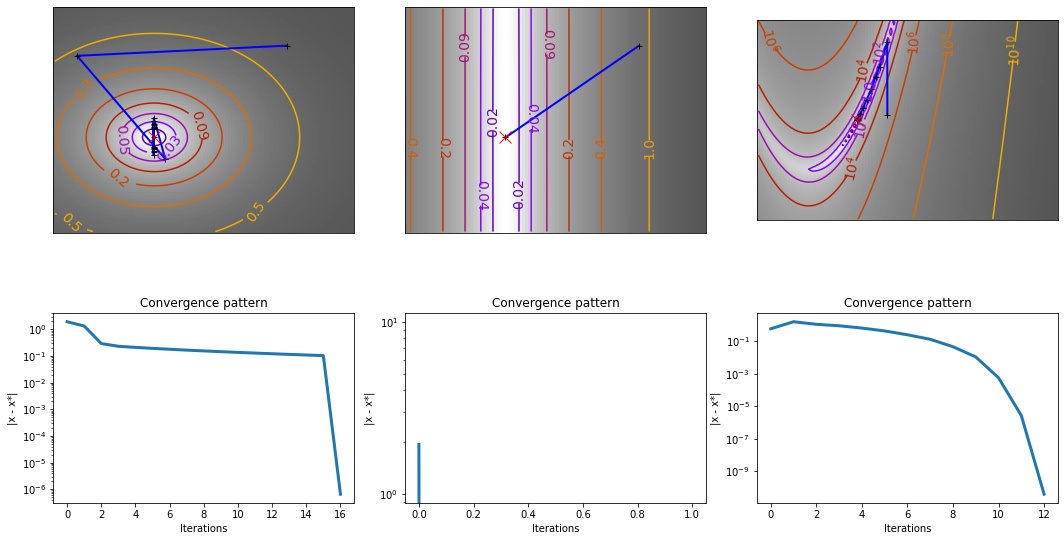

Convergence for C1 = 0.1

Running solver on case 1

Running solver on case 2

Running solver on case 3


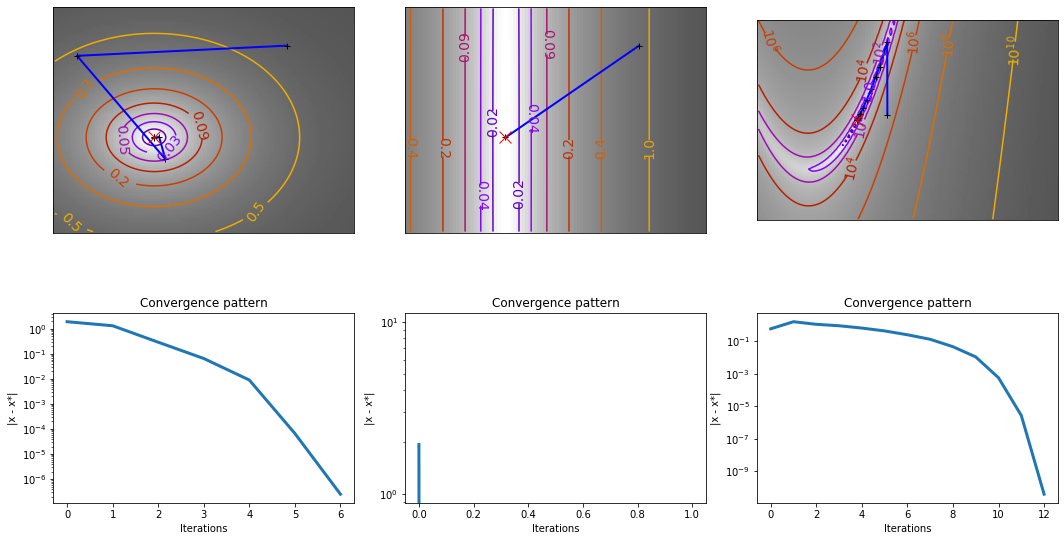

Convergence for C1 = 0.5

Running solver on case 1

Running solver on case 2

Running solver on case 3


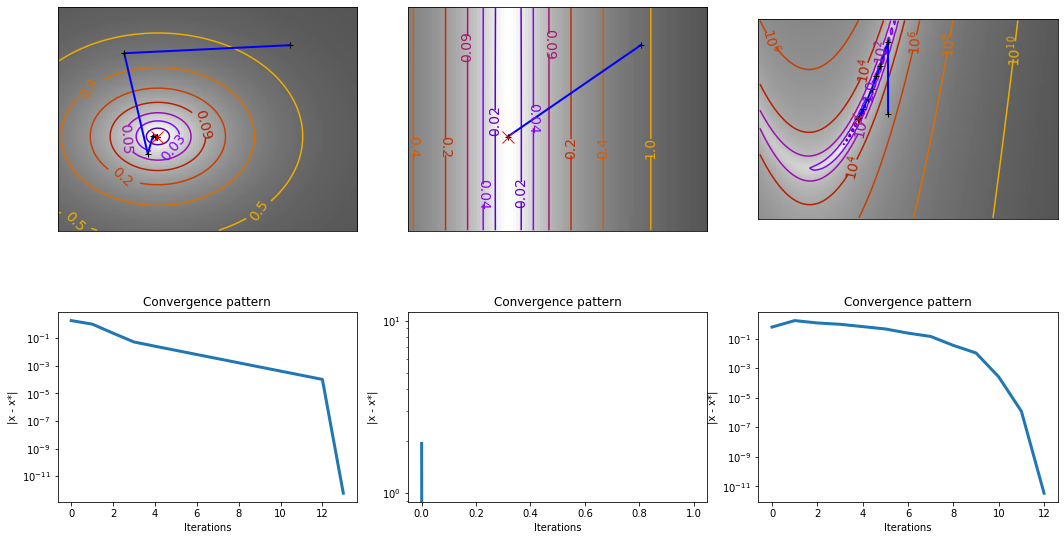

Convergence for C1 = 0.9

Running solver on case 1

Running solver on case 2

Running solver on case 3


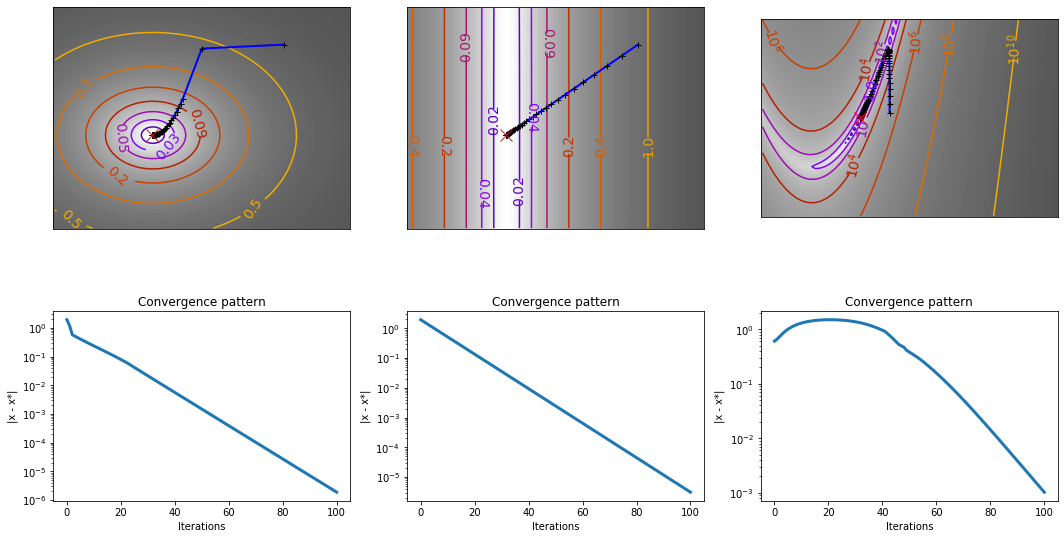

In [12]:
print ('######################################')
print ('             Effect of C1             ')
print ('######################################')

C2 = 0.95
threshold = 0.0001

C1 = 0.00001
print("Convergence for C1 = 0.00001")
test_solver(newton)

C1 = 0.1
print("Convergence for C1 = 0.1")
test_solver(newton)

C1 = 0.5
print("Convergence for C1 = 0.5")
test_solver(newton)

C1 = 0.9
print("Convergence for C1 = 0.9")
test_solver(newton)

######################################
             Effect of C2           
######################################
Convergence for C2 = 0.95

Running solver on case 1

Running solver on case 2

Running solver on case 3


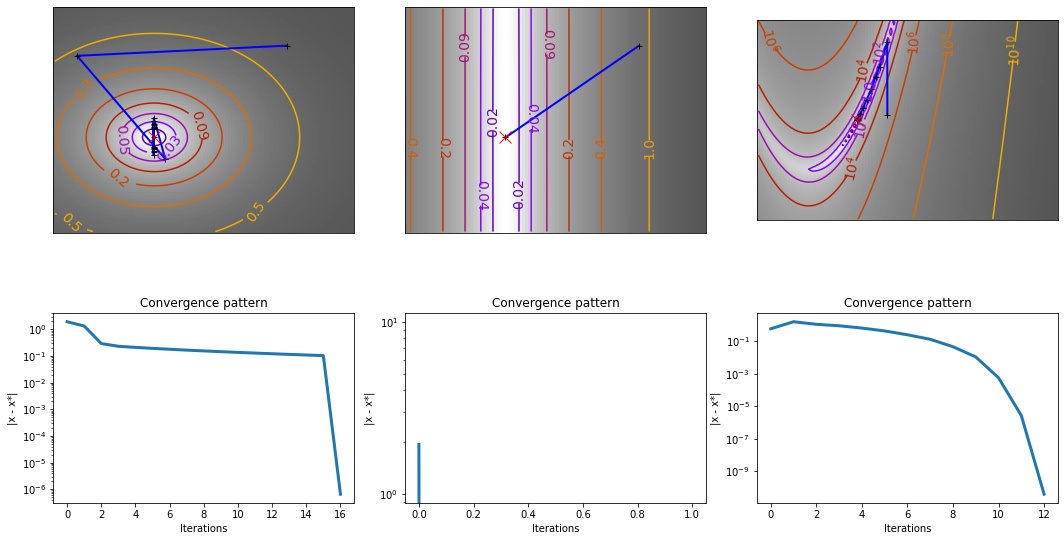

Convergence for C2 = 0.5

Running solver on case 1

Running solver on case 2

Running solver on case 3


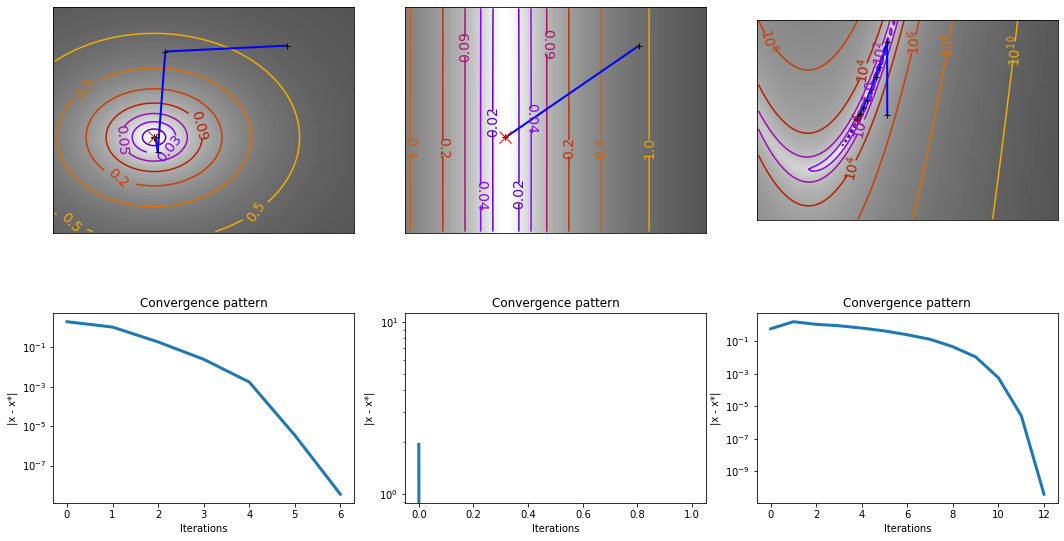

Convergence for C2 = 0.1

Running solver on case 1

Running solver on case 2

Running solver on case 3


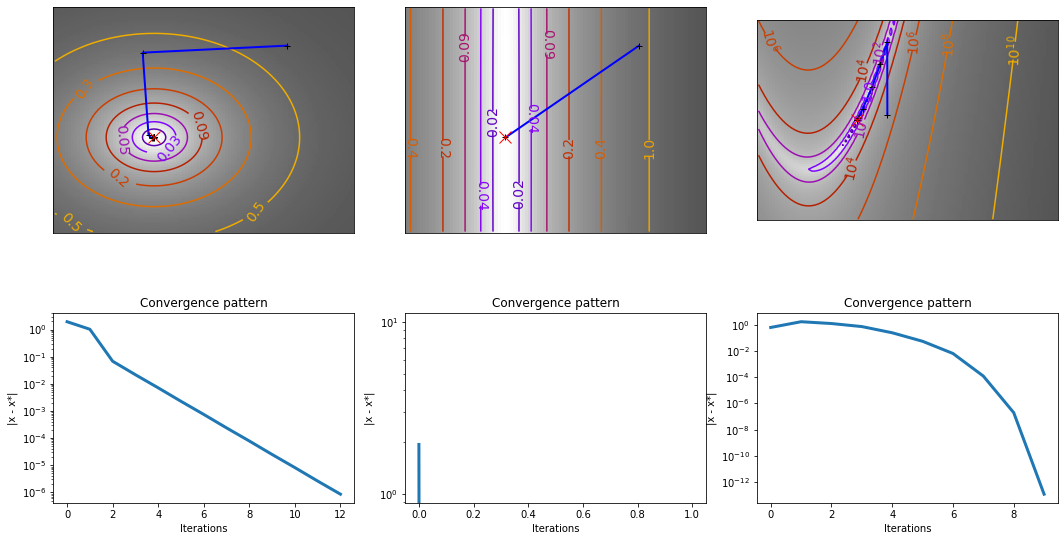

In [13]:
print ('######################################')
print ('             Effect of C2           ')
print ('######################################')

threshold = 0.0001
C1 = 0.00001

C2 = 0.95
print("Convergence for C2 = 0.95")
test_solver(newton)

C2 = 0.5
print("Convergence for C2 = 0.5")
test_solver(newton)

C2 = 0.1
print("Convergence for C2 = 0.1")
test_solver(newton)

<font color='navy'>
    
**Analysis of the convergence of the Newton Algorithm according to the parameters C1 and C2.**

- Effects of C1 <br>
We can remark that the larger C1 is, the smaller the successive steps are, and the less numerous the different directions of the updates are. 

**A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$) and the Rosenbrock function**

For the Gaussian Kernel as well as the Rosenbrock functions, we can remark that even a lite increase of the value taken by the coefficient C1 reduces the size of the successive steps as well as the number of elbows that is the number of different directions chosen by the Newton Algorithm for the successive updates before converging towards the optimum solution. The path followed by the successive iterates is more straightforward. Consequently, the increase of the coefficient C1 improves the stability of the slowdown of the Newton Algorithm by reducing the steps size. Besides the increase of the coefficient C1, improves the accuracy with which we manage to reach the optimum solution. 

**A badly conditioned quadratic function (but still strongly convex)** 

The quadratic function is badly conditioned but still strongly convex what implies that a small increase of the value taken by the coefficient C1 has no influence over the convergence of the Newton Algorithm towards the optimum solution. Indeed, this is due to the fact tath the allowed step size is still bigger than the distance between the initial point from which the algorithm starts and the optimum solution. <br/>

However, in the case where the value taken by the coefficient C1 becomes too large, then the size of the successive steps becomes very small and the convergence of the Newton Algorithm towards the optimum solution becomes linear, more stable and more accurate but the speed of convergence becomes very very slow. Even the Newton Algorithm for the quadractic strongly convex function requires a very large number of iterations to reach the optimum solution since the path of the algorithm between the initial point and the optimum solution is splitted in several small steps.  <br/>

Therefore, we have to find a trade off for the value of the coefficient C1.


- Effects of C2 <br>
Conversely to the effect of the coefficient C1 over the convergence of the Newton Algorithm, we can remark that the smaller the coefficient C2 is, the smaller the steps size is and the less numerous the number of different directions of the updates are.

**A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$) and the Rosenbrock function**

The effects observed when we reduce the value of the coefficient C2 over the convergence of the Newton Algorithm are similar than the one observed when we increase the value of the coefficient C1, even if the effects of the variation of the coefficient C2 are less significant than the one observed when we make varying the coefficient C1. <br/>

Indeed, the smaller the coefficient C2 becomes, the smaller the steps size becomes, the more linear and then more stable the convergence of the Newton Algorithm towards the optimum solution is. The fact that the succession of the small steps of updates performed to reach the optimum solution becomes linear and more stable when the coefficient C2 shrinks, then the number of different directions chosen by the Newton Algorithm (the number of elbows) before reaching the optimum solution is also reduced. Moreover, the smaller are the successive steps, the more accurate is the convergence towards the optimum solution that is the Newton Algorithm manages to reach the optimum solution instead of remaining around it for a long time before reaching it. In other words, the reducing of the steps size when we shrink the value of the coefficient C2 avoids the bouncing back of the algorithm around the optimum solution at the bottom of the bowl or on the side of the valley of the Rosenbrock function.

**A badly conditioned quadratic function (but still strongly convex)** 

Similarly as the case where increaser the value of the coefficient C1, the shrinking of the coefficient C2 leads to a reduction of the steps size what implies a linearization and a stabilization of the convergence of the Newton Algorithm towards the optimum solution. In the same way as previously we can remark that even a small reduction of the value of the coefficient C2 can lead to the convergence of the Newton Algorithm in only one step since the allowed steps size is bigger than the distance between the initial point from which the algorithm starts and the optimum solution. <br/>

However, like the results observed for the increase of the coefficient C1, we have to manage the shrinking of the coefficient C2. Indeed, when the value of the coefficient C2 is too small, then the steps size is very small what leads to a linearization and a stabilization of the convergence of the Newton Algorithm but the latter requires a very large number of iterations before reaching the optimum solution. Therefore, we have to find a good trade off for the values taken by the coefficient C2.
<font>

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [80]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = C1 # 0.0001
    c2 = C2 # 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x, d, grad_x, c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO 
        # B is a dxd dimensional matrix where d is the number of features
        B += (np.outer(s,s)/np.dot(s.T, y)) - np.outer(np.dot(y.T, B), np.dot(y.T, B))/np.dot(y.T, np.dot(B,y))
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


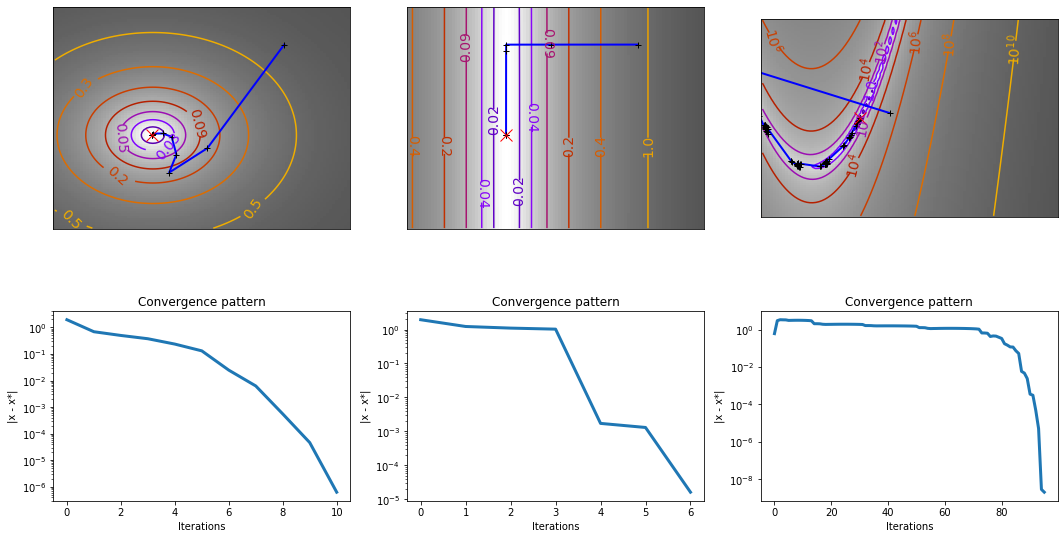

In [81]:
C1 = 0.0001
C2 = 0.95
test_solver(dfp)

**Comments**

<font color='blue'>
    
**A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$) and the Rosenbrock function**

For the non convex Gaussian Kernel and the Rosenbrock functions, we can realize that the first step is very often pretty bad what implies a low start for the convergence of the DFP (Davidon Fletcher and Powell) Algorithm. This is mainly due to a wrong step size. 

**A badly conditioned quadratic function (but still strongly convex)** 

Even if the quadratic function is badly conditioned, since the quadratic function it still strongly convex, this implies that the convergence of the DFP Algorithm requires a very low number of different directions for the successive updates steps (at most 2 orthogonal directions) as well as a low number of iterations to reach the optimum point.

For both functions, we can observe that the convergence of the DFP Algorithm towards the optimum solution is quadratic and non linear as the Newton Algorithm. <br>
   
**Contradiction**
    
The contradiction with what we saw in class come from the fact that $B_2 = H^{-1}$ (2-dimention space) and thus the algorithm should converge in less iterations. However, this is only true if the stepsize is optimal, which is probably not the case here.
<font>

######################################
             Effect of C1           
######################################
Convergence for C1 = 0.0001

Running solver on case 1

Running solver on case 2

Running solver on case 3


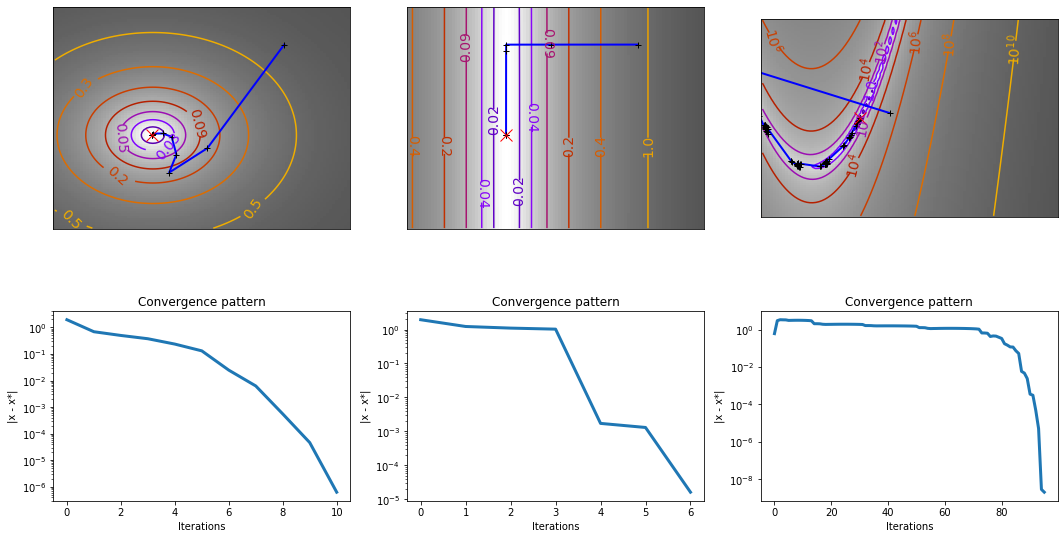

Convergence for C1 = 0.001

Running solver on case 1

Running solver on case 2

Running solver on case 3


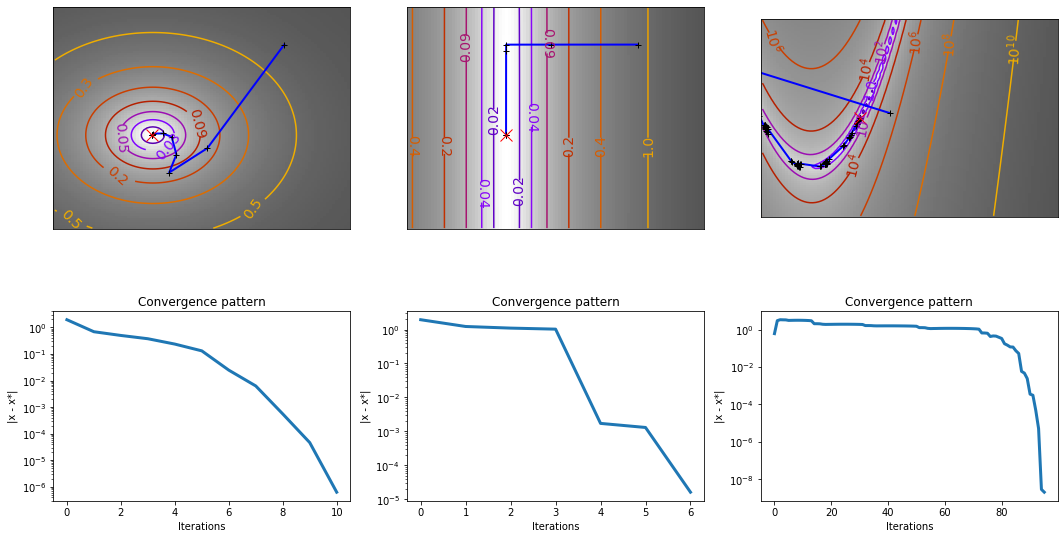

Convergence for C1 = 0.01

Running solver on case 1

Running solver on case 2

Running solver on case 3


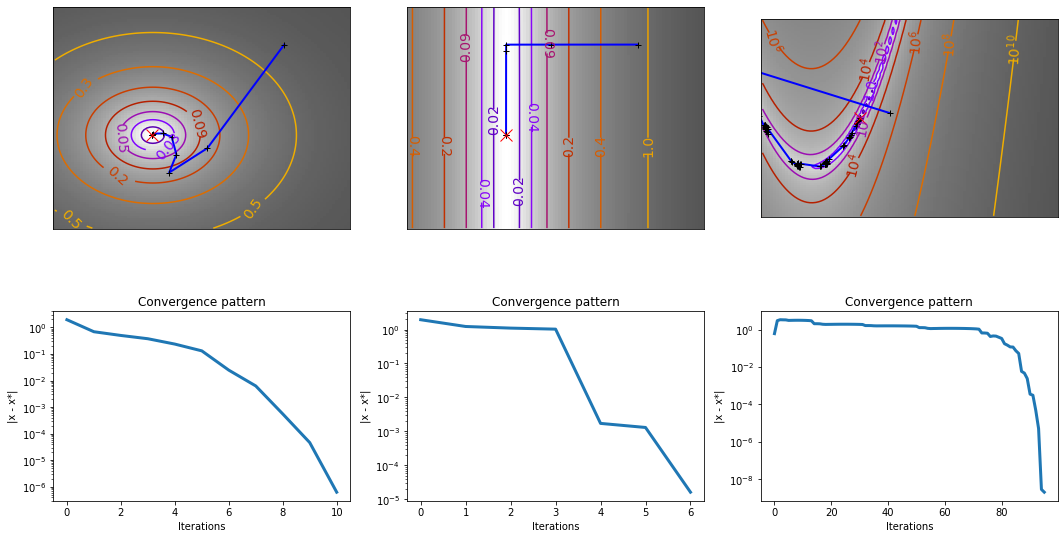

Convergence for C1 = 0.1

Running solver on case 1

Running solver on case 2

Running solver on case 3


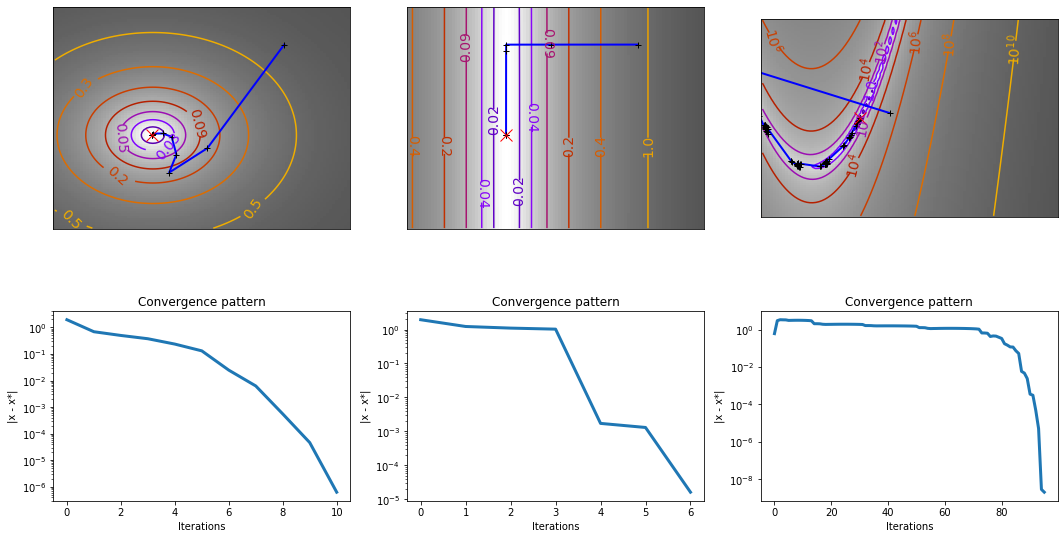

In [82]:
print ('######################################')
print ('             Effect of C1           ')
print ('######################################')

C2 = 0.95

C1 = 0.0001
print("Convergence for C1 = 0.0001")
test_solver(dfp)

C1 = 0.001
print("Convergence for C1 = 0.001")
test_solver(dfp)

C1 = 0.01
print("Convergence for C1 = 0.01")
test_solver(dfp)

C1 = 0.1
print("Convergence for C1 = 0.1")
test_solver(dfp)

######################################
             Effect of C2           
######################################
Convergence for C2 = 0.95

Running solver on case 1

Running solver on case 2

Running solver on case 3


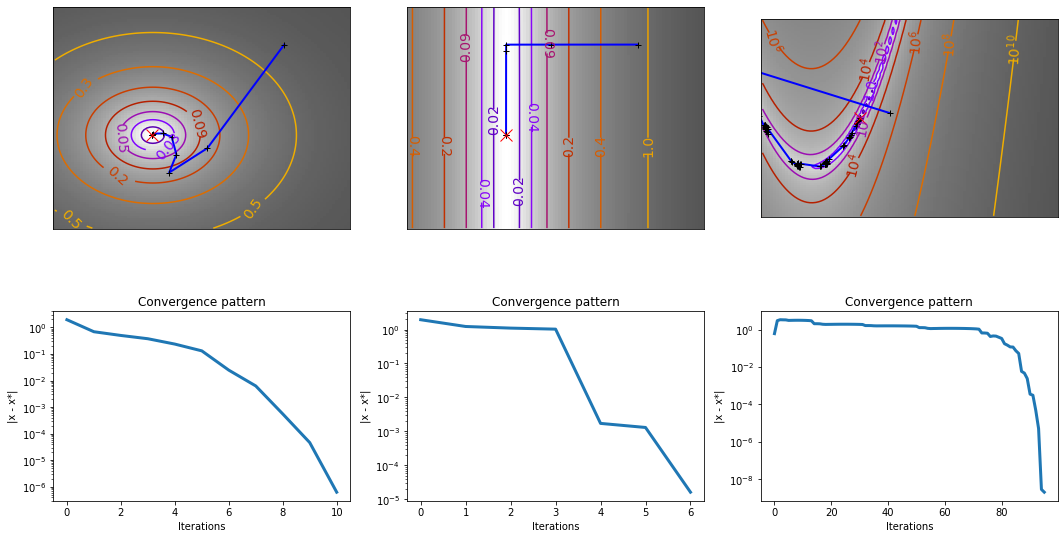

Convergence for C2 = 0.5

Running solver on case 1

Running solver on case 2

Running solver on case 3


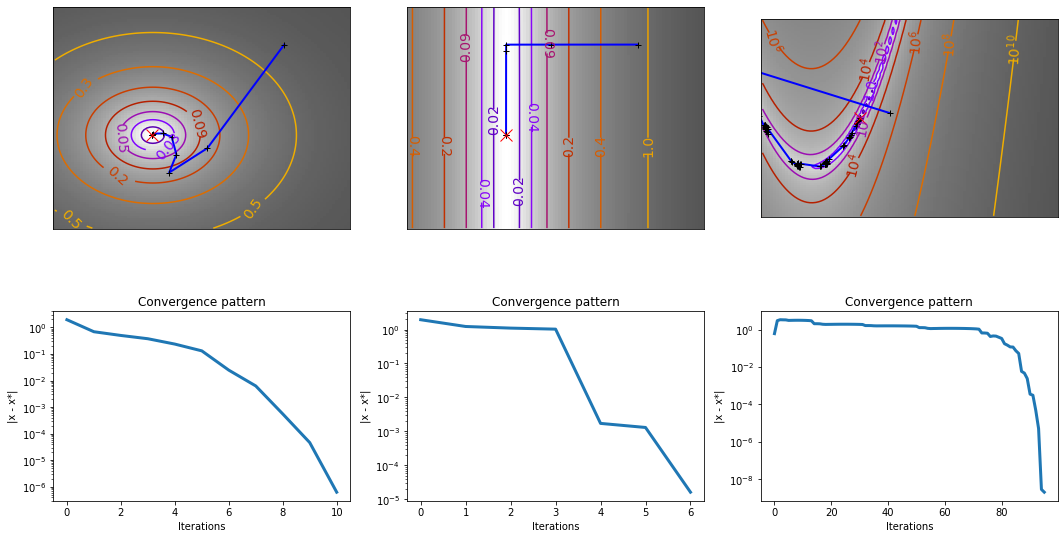

Convergence for C2 = 0.1

Running solver on case 1

Running solver on case 2

Running solver on case 3


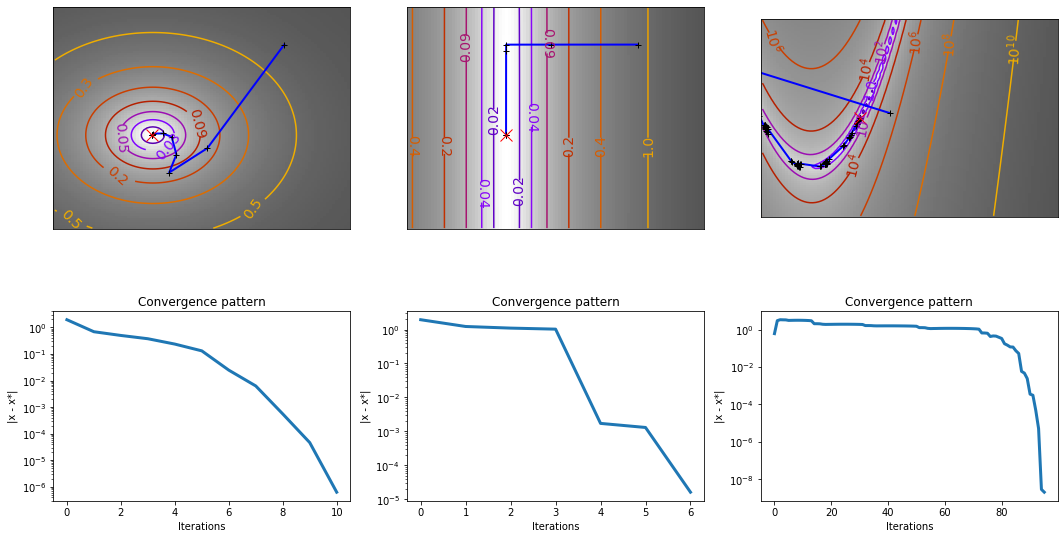

In [107]:
print ('######################################')
print ('             Effect of C2           ')
print ('######################################')

C1 = 0.0001

C2 = 0.95
print("Convergence for C2 = 0.95")
test_solver(dfp)

C2 = 0.5
print("Convergence for C2 = 0.5")
test_solver(dfp)

C2 = 0.1
print("Convergence for C2 = 0.1")
test_solver(dfp)


# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [111]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(np.linalg.inv(B), grad_x) ##CHANGE 'inverse of B' instead of B

        # Compute a step size using a line_search to satisfy the strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x, d, grad_x, c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the  HESSIAN  approximation. 
        
        # TODO 
        B += (np.outer(y, y) / (y.T @ s)) - (B @ np.outer(s, s) @ B) / (s.T @ B @ s)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


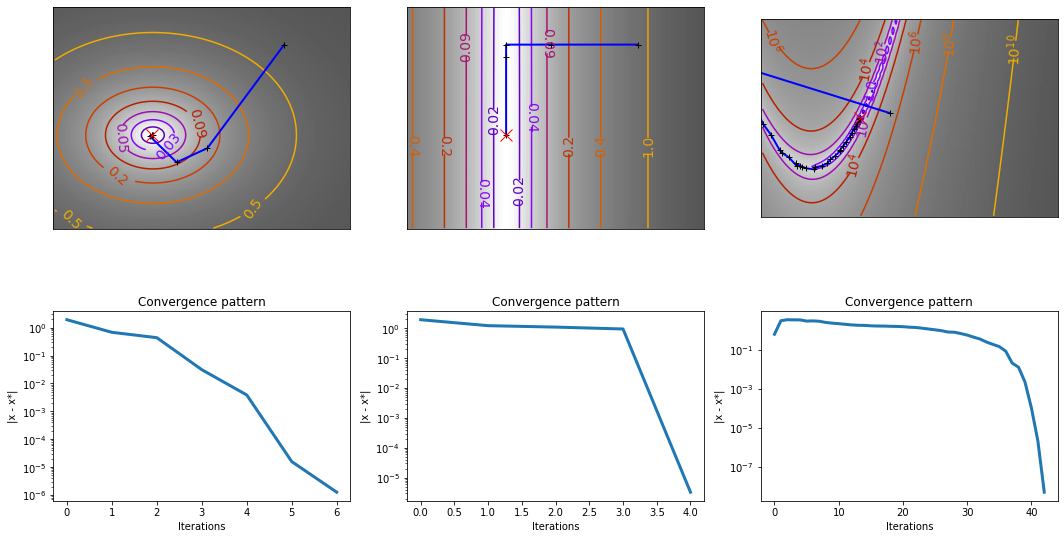

In [112]:
test_solver(bfgs)

**Comments**

<font color='blue'>
As expected, the BFGS algorithm requires a smaller number of iterations to reach the optimum solution than the Gradient Descent Algorithm, or the Newton Algorithm or even the DFP Algorithm for all of the three studied functions. <br/>
Similarly as the DFP Algorithm, the convergence of the BFGS Algorithm towards the optimum solution is quadratic. <br/>
Even if, the BFGS algorithm still suffers from the the bad performance of the first updates steps, this algorithm is less affected by the non-optimal directions provided by the line-search. That is the reason why the BFGS algorithm requires a smaller number of steps than the previous algorithms to converge towards the optimum solution. <br/>
<font>

# Part 4: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [108]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    for t in range(len(s_list)):
        alpha_list.append(rho_list[t] * np.dot(s_list[t], q))
        q -= alpha_list[t] * y_list[t]

    # TODO: second loop
    r = np.dot(B0, q)
    for t in range(len(s_list)):
        beta = rho_list[-(t+1)] * np.dot(y_list[-(t+1)], r)
        r += (alpha_list[-(t+1)] - beta) * s_list[-(t+1)]
    return -r

In [109]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x, d, grad_x, c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


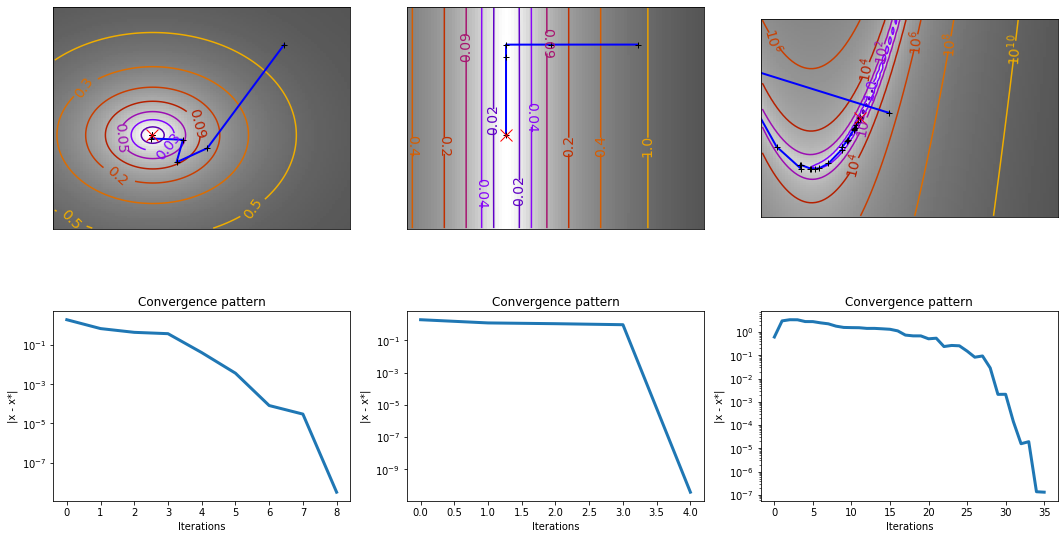

In [110]:
test_solver(lbfgs)

**Comment on what you observe**

<font color='blue'>
We can remark that this algorithm is very similar as the BFGS Algorithm in terms of number of iterations to reach the optimum solution. Indeed, the number of iterations required by the LBFGS Algorithm to reach the optimum solution is similar as the one required by the BFGS Algorithm. However, the number of variables stored at each iteration of the LBFGS Algorithm is lower as the number of variables stored at each iteration with the BFGS Algorithm, that is the reason why the LBFGS Algorithm requires less memory than the BFGS Algorithm. Consequently, we cannot notice a significant improvement with the LBFGS Algorithm concerning the number of iterations required to reach the optimum solution but we can remark a significant enhancement concerning the memory required. Finally, as for the BFGS Algorithm, the convergence of the LBFGS Algorithm is also quadratic.

</font>